5/10/15/20/25/30 일 기준 질문을 30개씩 샘플링 X 10번 반복  
각 버전 별로 난이도 비율 계산하여 chow test 수행 
일자별로 계산하여 시각화

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')
sys.path.insert(1, p)
sys.path.insert(1, pp)

In [2]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lib.stats.stats as st
import lib.annotation.Result_Prep as rp
import config.config as conf


INFO 10-24 20:07:50 [__init__.py:216] Automatically detected platform cuda.


In [3]:
fig_path = './fig/'
path = f'../LLM/result/'
file_list = os.listdir(path)

In [4]:
fig_path = './fig/'
colors = plt.get_cmap('tab20').colors 

In [5]:
plt.get_cmap('tab20').colors 

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.74117647

In [6]:
r_p = rp.Result_Prep()

In [7]:
sample1_list = sorted([y for y in [x for x in file_list if x.isdigit()] if (int(y)>=50000)&(int(y)<11110000)])
sample2_list = sorted([y for y in [x for x in file_list if x.isdigit()] if (int(y)>=11110000) & (int(y)<=98880000)])
# ver_list = sorted([y for y in [x for x in file_list if x.isdigit()] if (int(y)>=11110000) & (int(y)<=98880000)])

In [8]:
def get_tot_calc(ver_list) : 
    tot_calc = pd.DataFrame()
    for listid in ver_list:
        df = r_p.make_one_file(listid)
        if isinstance(df, pd.core.frame.DataFrame):
            df = r_p.pp_df(df, 5)
            df = r_p.calc_rate(df)
            tot_calc = pd.concat([tot_calc, df], axis = 0)
    return tot_calc

    

In [9]:
s1_tot_calc = get_tot_calc(sample1_list)
s2_tot_calc = get_tot_calc(sample2_list)

In [10]:
def get_proportion_per_level(tot_calc) : 
    df_date = r_p.pp_date(tot_calc)
    m_chk_cnt_dict = dict()

    for x in range(0, 3):
        df = tot_calc[tot_calc['o_result'] ==str(x)]

        df_merge = pd.merge(df_date, df[['creationdate', 'rel_days', 'o_result', 'rate']], on = 'creationdate', how='left')
        df_merge.loc[df_merge['o_result'].isna(), 'rate'] = 0

        df_merge.loc[:, 'o_result'] = str(x)
        df_merge['rel_days'] = np.where(df_merge['rel_days'].isna(), (df_merge['creationdate'] - datetime.datetime(2022,11,30)).dt.days, df_merge['rel_days'])
        m_chk_cnt_dict[x] = df_merge
    return m_chk_cnt_dict

In [11]:
s1_tot_dict = get_proportion_per_level(s1_tot_calc)
s2_tot_dict = get_proportion_per_level(s2_tot_calc)

In [12]:
s1_major_xticks = s1_tot_dict[0]['creationdate'].to_list()
s2_major_xticks = s2_tot_dict[0]['creationdate'].to_list()

In [13]:
s1_tot_prop = s1_tot_calc.groupby('o_result')[['r_cnt']].sum().reset_index()
s2_tot_prop = s2_tot_calc.groupby('o_result')[['r_cnt']].sum().reset_index()

In [14]:
s1_tot_prop['proportion'] = s1_tot_prop['r_cnt'].div(s1_tot_prop['r_cnt'].sum())*100
s2_tot_prop['proportion'] = s2_tot_prop['r_cnt'].div(s2_tot_prop['r_cnt'].sum())*100

In [15]:
s1_tot_prop

,o_result,r_cnt,proportion
0,0,6235,22.368515
1,1,17113,61.394131
2,2,4526,16.237354


In [16]:
s2_tot_prop

,o_result,r_cnt,proportion
0,0,3157,21.925134
1,1,8850,61.462602
2,2,2392,16.612265


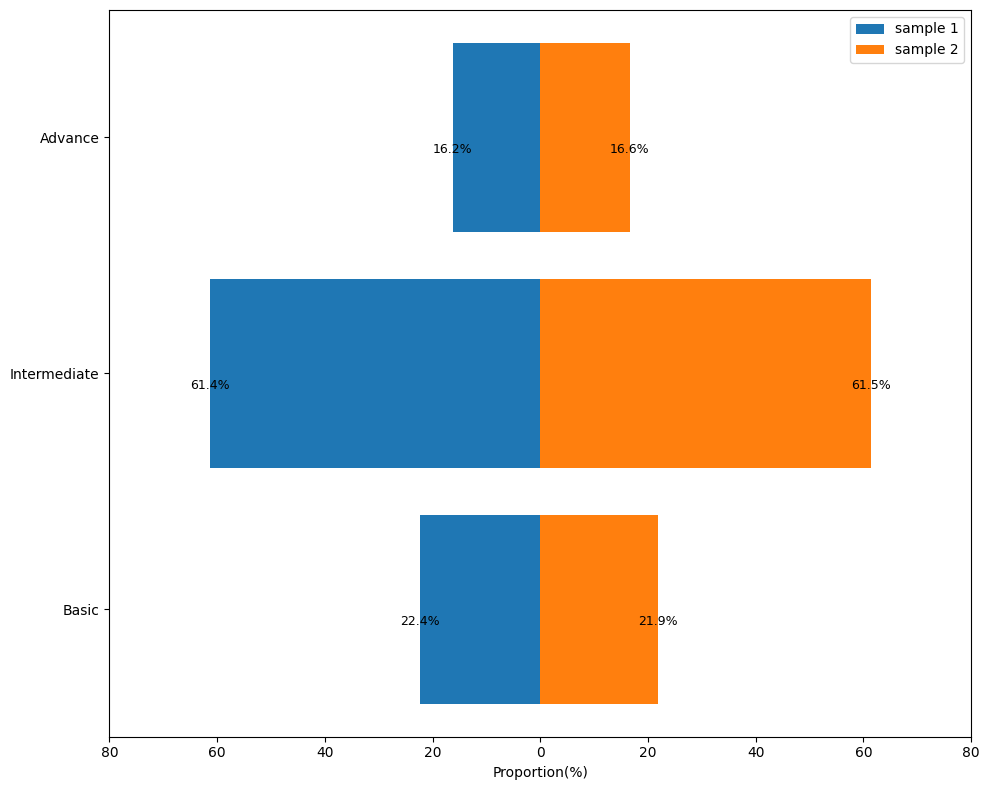

In [17]:
import matplotlib.pyplot as plt
import numpy as np

y = np.arange(len(s2_tot_prop['o_result']))

# 그래프 설정
plt.figure(figsize=(10, 8))
bar_smp1 = plt.barh(y, [-x for x in s1_tot_prop['proportion']], color=colors[0], label='sample 1')  # 음수로 표현
bar_smp2 = plt.barh(y, s2_tot_prop['proportion'], color=colors[2], label='sample 2')

# y축 레이블 (연령대)
plt.yticks(y, ['Basic', 'Intermediate', 'Advance'])
plt.xlabel('Proportion(%)')
# plt.title('Proportion of Difficulty Level for Each Sample')
plt.legend(loc='upper right')

for i in y:

    percent_smp1 = s1_tot_prop.loc[s1_tot_prop['o_result'] == str(i), 'proportion'].values[0]
    percent_smp2 = s2_tot_prop.loc[s2_tot_prop['o_result'] == str(i), 'proportion'].values[0]

    # 남자 바 오른쪽 끝 (음수 방향 → 왼쪽)
    plt.text([-x for x in s1_tot_prop['proportion']][i], y[i] - 0.08, f"{percent_smp1:.1f}%", ha='center', va='bottom', color='black', fontsize=9)

    # 여자 바 오른쪽 끝 (양수 방향 → 오른쪽)
    plt.text(s2_tot_prop['proportion'][i], y[i] - 0.08, f"{percent_smp2:.1f}%", ha='center', va='bottom', color='black', fontsize=9)


# x축의 눈금 표시를 절대값으로 (음수 제거)
xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{abs(int(x)):,}" for x in xticks])
plt.tight_layout()
plt.savefig(f"{fig_path}SI_Data_Fig5.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
[ 
   "#4575b4",  # deep blue
    "#91bfdb",  # light blue
    "#e0f3f8",  # pale blue
    "#a6d96a",  # light green
    "#1a9850",  # green
    "#d9ef8b",  # lime yellow
    "#fee08b",  # beige
    "#fdae61",  # soft orange
    "#f46d43",  # coral orange
    "#d73027"   # muted red
    ]

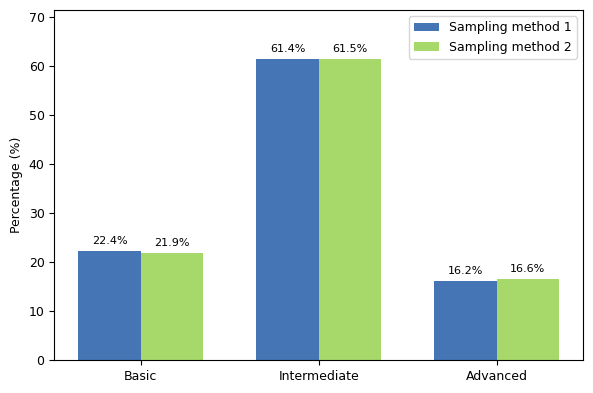

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 라벨 및 위치
labels = ['Basic', 'Intermediate', 'Advanced']
x = np.arange(len(labels))  # x축 위치
width = 0.35  # 막대 너비

# 색상 설정
sample1_color = "#4575b4"
sample2_color = "#a6d96a"  # Vermilion

# 그래프 생성
fig, ax = plt.subplots(figsize=(6, 4))
bar1 = ax.bar(x - width/2, s1_tot_prop['proportion'], width, label='Sampling method 1', color=sample1_color)
bar2 = ax.bar(x + width/2, s2_tot_prop['proportion'], width, label='Sampling method 2', color=sample2_color)

# 축 설정
ax.set_ylabel('Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

# 수치 레이블 추가
for i in range(len(labels)):
    ax.text(x[i] - width/2, s1_tot_prop['proportion'][i] + 1, f"{s1_tot_prop['proportion'][i]:.1f}%", 
            ha='center', va='bottom', fontsize=8)
    ax.text(x[i] + width/2, s2_tot_prop['proportion'][i] + 1, f"{s2_tot_prop['proportion'][i]:.1f}%", 
            ha='center', va='bottom', fontsize=8)

# y축 범위 약간 여유 주기
ax.set_ylim(0, max(s1_tot_prop['proportion'].max(), s2_tot_prop['proportion'].max()) + 10)

# 폰트 설정
plt.rcParams['font.size'] = 9

# 레이아웃 정리 및 저장
plt.tight_layout()
plt.savefig(f"{fig_path}SI_2.B_Fig6.png", dpi=300, bbox_inches='tight')
plt.show()
